In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fastbook

In [3]:
names = {'fender_telecaster': "Fender Telecaster",
         'gibson_les_paul':   "Gibson Les Paul",
         'gibson_es':         "Gibson ES", 
         'gibson_explorer':   "Gibson Explorer",
         'gibson_flying_v':   "Gibson Flying V",
         'fender_mustang':    "Fender Mustang",
         'fender_stratocaster': 'Fender Stratocaster', 
         'gibson_sg':         "Gibson SG",
         'fender_jaguar':     "Fender Jaguar",
         'gibson_firebird':   "Gibson Firebird", 
         'fender_jazzmaster': "Fender Jazzmaster"}

In [1]:
from fastbook import *
from fastai import vision
from PIL import Image
import os, pathlib
%matplotlib inline

In [ ]:
urls = [search_images_ddg(str(f'{name}'), max_images=760)  for names in names.values()]

In [2]:
generic_path = pathlib.Path('/content/drive/MyDrive/DATA/images')

In [ ]:
 def downloadAndCreatePath(myurls): 
  for bunch in myurls:
    for url in range(len(bunch)):
      a = myurls.index(bunch)
      b = list(names.keys())[a]
        try:
          download_url(bunch[url], os.makedirs(f'{generic_path/b}', exist_ok =True))
        except:
          pass        


In [ ]:
downloadAndCreatePath(urls)

In [ ]:
paths = get_image_files(generic_path);
checking_failed = verify_images(paths)

In [ ]:
checking_failed

(#0) []

In [ ]:
categorie = ['fender_telecaster', 'gibson_les_paul', 'gibson_es', 'gibson_explorer', 'gibson_flying_v', 'fender_mustang', 'fender_stratocaster',
             'gibson_sg', 'fender_jaguar', 'gibson_firebird', 'fender_jazzmaster']
for cat in categories:
  for file in os.listdir(generic_path/cat):
    if file.endswith('.png'):
      os.remove(file) 

In [13]:
  SIZE = 224
  tfms = setup_aug_tfms([Rotate(draw = 30, p = 0.6, size = SIZE), 
                        Zoom(draw = 1.2, p = 0.6, size = SIZE),
                        Warp(draw_x=-0.2, draw_y=0.2, p=0.6, size = SIZE),
                        Flip( p=0.75, size=SIZE)])


  guitars = DataBlock(
                  blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSplitter(valid_pct=0.15, seed=42),
                  get_y=parent_label,
                  item_tfms=Resize(460),
                  batch_tfms = [*tfms, Normalize.from_stats(*imagenet_stats)]
                )

In [14]:
guitars_dl = guitars.dataloaders(generic_path)

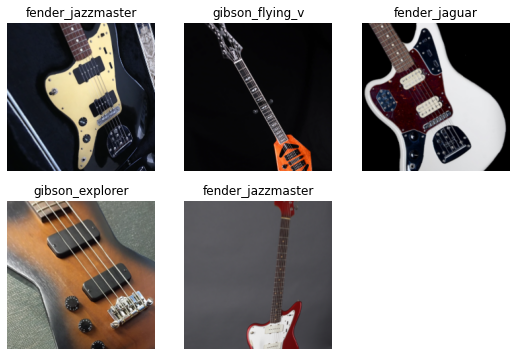

In [15]:
guitars_dl.train.show_batch(max_n=5)

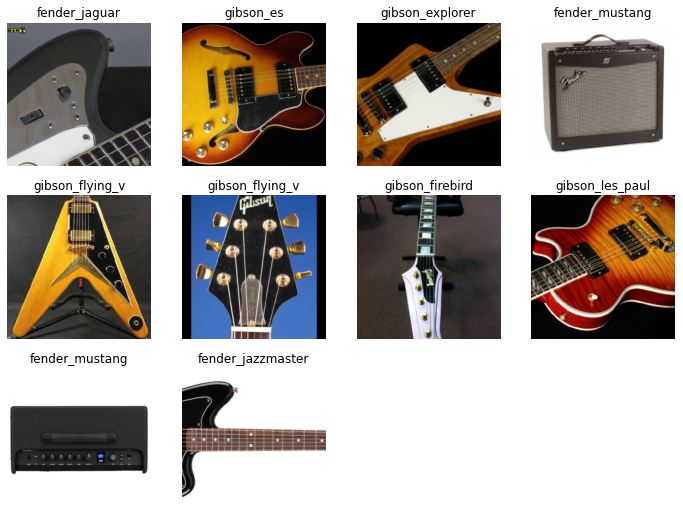

In [16]:
guitars_dl.valid.show_batch(max_n=10)

In [17]:
learner = cnn_learner(guitars_dl, resnet34, metrics=error_rate, loss_func=CrossEntropyLossFlat(), wd=1e-1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learner.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [18]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.884491,1.278649,0.404255,10:19
1,1.834949,0.873955,0.272340,04:10
2,1.347895,0.738429,0.218440,04:11
3,1.096108,0.681715,0.204255,04:13
4,0.962702,0.670884,0.195745,04:15


In [24]:
learner.save('/content/drive/MyDrive/models/stage-1-resnet34')

Path('/content/drive/MyDrive/models/stage-1-resnet34.pth')

In [25]:
learner.unfreeze()

SuggestedLRs(valley=0.00010964782268274575)

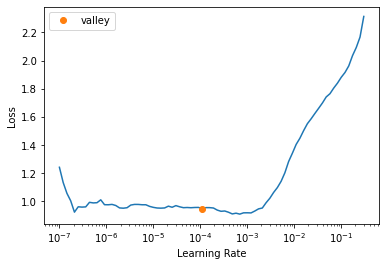

In [26]:
learner.lr_find()

In [29]:
learner.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.855487,0.620614,0.174468,04:23
1,0.722869,0.493394,0.143262,04:24
2,0.578666,0.450311,0.123404,04:28


In [30]:
learner.save('/content/drive/MyDrive/models/stage-2-resnet34')

Path('/content/drive/MyDrive/models/stage-2-resnet34.pth')

In [31]:
learner.load('/content/drive/MyDrive/models/stage-2-resnet34')

In [32]:
interpretation = ClassificationInterpretation.from_learner(learner.to_fp16())

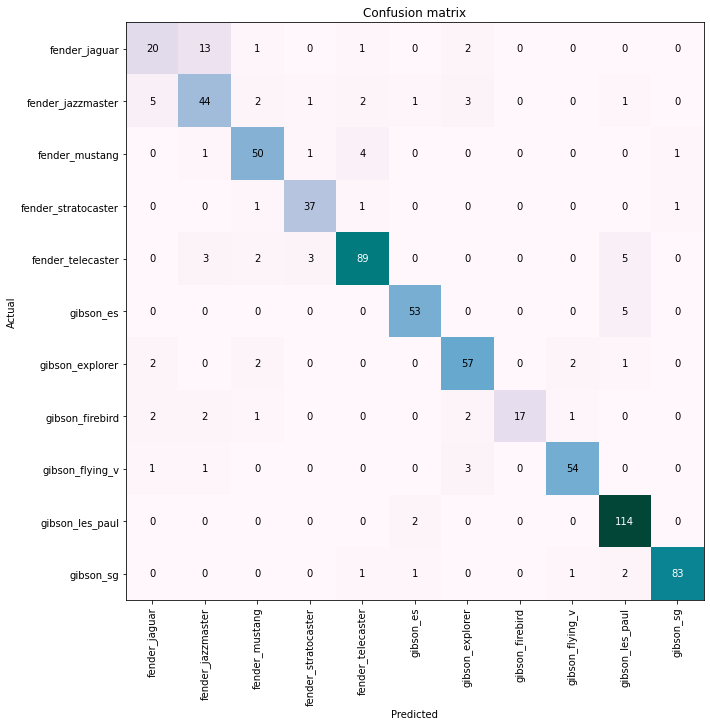

In [34]:
interpretation.plot_confusion_matrix(figsize=(10,10), cmap='PuBuGn')

In [37]:
learner.export()